## Is it A good day to go out Diving?

## Stakeholders: Dive Buddies

The stakeholder is a diving social club. They hangout in the Chicago waterfront region. 

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix,\
classification_report, precision_recall_curve, plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB




sns.set_style('whitegrid')

In [2]:
# load and import dataset using pandas

df = pd.read_csv('data/bwq.csv',parse_dates=True)

In [3]:
# Read first 5 lines of dataframe
df.head()

,Beach Name,Measurement Timestamp,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life,Measurement Timestamp Label,Measurement ID
0,Montrose Beach,08/30/2013 08:00:00 AM,20.3,1.18,0.891,0.080,3.0,9.4,8/30/2013 8:00 AM,MontroseBeach201308300800
1,Ohio Street Beach,05/26/2016 01:00:00 PM,14.4,1.23,NaN,0.111,4.0,12.4,05/26/2016 1:00 PM,OhioStreetBeach201605261300
2,Calumet Beach,09/03/2013 04:00:00 PM,23.2,3.63,1.201,0.174,6.0,9.4,9/3/2013 4:00 PM,CalumetBeach201309031600
3,Calumet Beach,05/28/2014 12:00:00 PM,16.2,1.26,1.514,0.147,4.0,11.7,5/28/2014 12:00 PM,CalumetBeach201405281200
4,Montrose Beach,05/28/2014 12:00:00 PM,14.4,3.36,1.388,0.298,4.0,11.9,5/28/2014 12:00 PM,MontroseBeach201405281200


In [4]:
# view data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34923 entries, 0 to 34922
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Beach Name                   34923 non-null  object 
 1   Measurement Timestamp        34917 non-null  object 
 2   Water Temperature            34917 non-null  float64
 3   Turbidity                    34917 non-null  float64
 4   Transducer Depth             10034 non-null  float64
 5   Wave Height                  34690 non-null  float64
 6   Wave Period                  34690 non-null  float64
 7   Battery Life                 34917 non-null  float64
 8   Measurement Timestamp Label  34917 non-null  object 
 9   Measurement ID               34923 non-null  object 
dtypes: float64(6), object(4)
memory usage: 2.7+ MB


In [5]:
# view summary statistics of numerical columns
df.describe()

,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life
count,34917.000000,34917.000000,10034.000000,34690.000000,34690.000000,34917.000000
mean,19.363387,4.823575,1.570235,-1516.116166,-1512.482041,11.038205
std,3.356908,33.506600,0.175118,12220.244835,12220.696864,0.771769
min,0.000000,0.000000,-0.082000,-99999.992000,-100000.000000,4.800000
25%,17.100000,0.660000,1.426000,0.110000,3.000000,10.600000
50%,19.600000,1.260000,1.578000,0.154000,3.000000,11.000000
75%,22.000000,2.540000,1.721000,0.201000,4.000000,11.500000
max,31.500000,1683.480000,2.214000,1.467000,10.000000,13.300000


Ocean wave height (technically referred to as amplitude) is a measurement of the vertical distance of the wave from the average height of the wave. The wave axis is the still water level of the ocean, and is usually equated to zero. Wave height above and below the average are measured as positive and negative values, respectively. Could that be the reason we have negative values in the 'Wave Height" and "Wave Period" columns?

However, on closer inspection, notice these two columns have extreme-looking values as their minimum values. These could be attributed to clerical errors, or perhaps filling in for unknown values as it was done several years ago (before the advent of NaNs). 

However, it does seem like the above -99999.92 and -100000.0 were arbitrarily entered as values in the above columns for some odd reason. 

Also, it is noted from the df.info() output that the timestamp measurements are object datatypes. 

In [6]:
len(df[df['Wave Height'] < 0]) / len(df)

0.015061707184377058

These arbitrarily inputted figures account for a little less than 2% of the dataset. At this point of exploring the data, I will note this and make a decision about handling this subset of the dataset as I keep exploring and looking at the trends.

In [7]:
df[df['Transducer Depth'] < 0]

,Beach Name,Measurement Timestamp,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life,Measurement Timestamp Label,Measurement ID
859,63rd Street Beach,06/12/2014 12:00:00 PM,25.4,3.45,-0.072,0.031,9.0,12.2,06/12/2014 12:00 PM,63rdStreetBeach201406121200
909,Osterman Beach,06/12/2014 03:00:00 PM,20.5,0.00,-0.082,0.055,2.0,12.7,06/12/2014 3:00 PM,OstermanBeach201406121500


These two readings also have negative transducer height values, which seems odd. However, just like the wave height measurements above, I note this off-values and will make a decision as to the usability while I keep exploring the dataset.

Meanwhile, we are looking out for outliers in the target variable.

In [8]:
df[df['Turbidity'] > 100]

,Beach Name,Measurement Timestamp,Water Temperature,Turbidity,Transducer Depth,Wave Height,Wave Period,Battery Life,Measurement Timestamp Label,Measurement ID
7547,63rd Street Beach,07/27/2014 02:00:00 PM,18.9,1683.48,NaN,NaN,NaN,5.3,07/27/2014 2:00 PM,63rdStreetBeach201407271400
7710,63rd Street Beach,07/27/2014 04:00:00 PM,18.1,479.35,NaN,NaN,NaN,5.2,07/27/2014 4:00 PM,63rdStreetBeach201407271600
7784,63rd Street Beach,07/27/2014 10:00:00 PM,17.7,1680.92,NaN,NaN,NaN,5.3,07/27/2014 10:00 PM,63rdStreetBeach201407272200
8319,Montrose Beach,05/31/2015 02:00:00 PM,9.6,112.81,NaN,0.546,6.0,11.1,05/31/2015 2:00 PM,MontroseBeach201505311400
8320,Osterman Beach,05/31/2015 02:00:00 PM,9.5,151.81,NaN,0.504,6.0,10.9,05/31/2015 2:00 PM,OstermanBeach201505311400
...,...,...,...,...,...,...,...,...,...,...
28360,Rainbow Beach,09/11/2015 08:00:00 PM,19.6,136.26,NaN,0.558,6.0,11.6,09/11/2015 8:00 PM,RainbowBeach201509112000
30186,Rainbow Beach,09/30/2015 07:00:00 PM,9.8,1362.80,NaN,-99999.992,-100000.0,10.5,09/30/2015 7:00 PM,RainbowBeach201509301900
30192,Rainbow Beach,09/30/2015 11:00:00 PM,16.4,217.08,NaN,-99999.992,-100000.0,10.4,09/30/2015 11:00 PM,RainbowBeach201509302300
30198,Rainbow Beach,10/01/2015 06:00:00 AM,15.8,357.35,NaN,-99999.992,-100000.0,10.4,10/01/2015 6:00 AM,RainbowBeach201510010600


In [9]:
beach_names = []

for name in df['Beach Name'].unique():
    beach_names.append(name)
    
beach_names

['Montrose Beach',
 'Ohio Street Beach',
 'Calumet Beach',
 '63rd Street Beach',
 'Osterman Beach',
 'Rainbow Beach']

In [10]:
# Filtering out the extreme wave height and wave period values:
df = df[(df['Wave Height'] != -99999.992) & 
        (df['Wave Period'] != -100000.0)].drop(columns='Transducer Depth').dropna()

In [11]:
df

,Beach Name,Measurement Timestamp,Water Temperature,Turbidity,Wave Height,Wave Period,Battery Life,Measurement Timestamp Label,Measurement ID
0,Montrose Beach,08/30/2013 08:00:00 AM,20.3,1.18,0.080,3.0,9.4,8/30/2013 8:00 AM,MontroseBeach201308300800
1,Ohio Street Beach,05/26/2016 01:00:00 PM,14.4,1.23,0.111,4.0,12.4,05/26/2016 1:00 PM,OhioStreetBeach201605261300
2,Calumet Beach,09/03/2013 04:00:00 PM,23.2,3.63,0.174,6.0,9.4,9/3/2013 4:00 PM,CalumetBeach201309031600
3,Calumet Beach,05/28/2014 12:00:00 PM,16.2,1.26,0.147,4.0,11.7,5/28/2014 12:00 PM,CalumetBeach201405281200
4,Montrose Beach,05/28/2014 12:00:00 PM,14.4,3.36,0.298,4.0,11.9,5/28/2014 12:00 PM,MontroseBeach201405281200
...,...,...,...,...,...,...,...,...,...
34918,Ohio Street Beach,09/12/2017 12:00:00 PM,19.9,2.61,0.187,3.0,10.5,09/12/2017 12:00 PM,OhioStreetBeach201709121200
34919,Ohio Street Beach,09/12/2017 01:00:00 PM,19.8,0.00,0.187,3.0,10.5,09/12/2017 1:00 PM,OhioStreetBeach201709121300
34920,Ohio Street Beach,09/12/2017 03:00:00 PM,22.3,0.00,0.187,3.0,10.5,09/12/2017 3:00 PM,OhioStreetBeach201709121500
34921,Ohio Street Beach,09/12/2017 05:00:00 PM,21.1,26.97,0.187,3.0,9.4,09/12/2017 5:00 PM,OhioStreetBeach201709121700


In [12]:
# converting Measurement Timestamp variable to a datetime object
time_list = ['Measurement Timestamp', 'Measurement Timestamp Label']
df['Measurement Timestamp'] = pd.to_datetime(df['Measurement Timestamp'])
# df.set_index('Measurement Timestamp')


In [75]:
df.corr()

,Water Temperature,Turbidity,Wave Height,Wave Period,Battery Life,Turbidity_level,Month,date_offset
Water Temperature,1.000000,-0.005496,-0.072886,-0.117378,-0.151984,-0.118316,0.505818,0.508412
Turbidity,-0.005496,1.000000,0.121400,0.050527,-0.060246,0.533923,0.037968,0.036874
Wave Height,-0.072886,0.121400,1.000000,0.039169,-0.020863,0.358278,0.012709,0.010808
Wave Period,-0.117378,0.050527,0.039169,1.000000,0.005517,0.120021,0.029881,0.029682
Battery Life,-0.151984,-0.060246,-0.020863,0.005517,1.000000,-0.089814,-0.174689,-0.182189
Turbidity_level,-0.118316,0.533923,0.358278,0.120021,-0.089814,1.000000,0.049945,0.049148
Month,0.505818,0.037968,0.012709,0.029881,-0.174689,0.049945,1.000000,0.996840
date_offset,0.508412,0.036874,0.010808,0.029682,-0.182189,0.049148,0.996840,1.000000


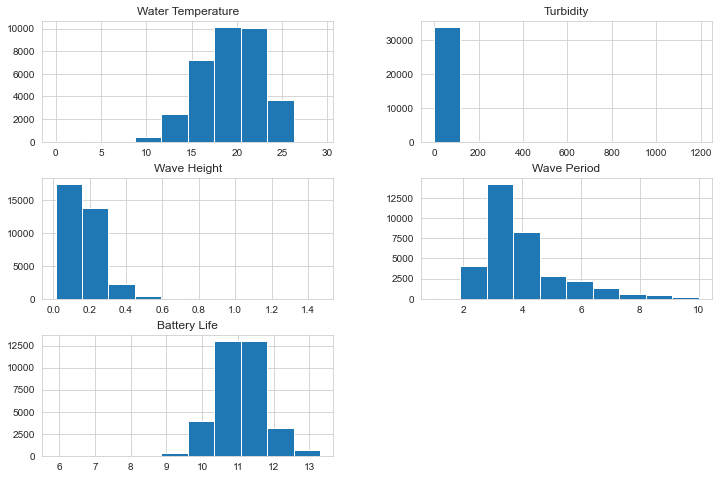

In [14]:
# Visualizing the features
df.hist(figsize=(12,8),bins=10);

## Binning the turbidity level

In [15]:
# Define bins
bins = [0, 5, 35, 50, 2000]

In [16]:
# Define the corresponding category for each bin
Levels = [0, 1, 2, 3]

In [17]:
# create a new column mapping water turbidity to a turbidity level
df['Turbidity_level'] = pd.cut(df['Turbidity'],bins,labels=Levels,ordered=True,include_lowest=True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34164 entries, 0 to 34922
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Beach Name                   34164 non-null  object        
 1   Measurement Timestamp        34164 non-null  datetime64[ns]
 2   Water Temperature            34164 non-null  float64       
 3   Turbidity                    34164 non-null  float64       
 4   Wave Height                  34164 non-null  float64       
 5   Wave Period                  34164 non-null  float64       
 6   Battery Life                 34164 non-null  float64       
 7   Measurement Timestamp Label  34164 non-null  object        
 8   Measurement ID               34164 non-null  object        
 9   Turbidity_level              34164 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(5), object(3)
memory usage: 2.6+ MB


In [19]:
# check for null vales
df.isna().any()

Beach Name                     False
Measurement Timestamp          False
Water Temperature              False
Turbidity                      False
Wave Height                    False
Wave Period                    False
Battery Life                   False
Measurement Timestamp Label    False
Measurement ID                 False
Turbidity_level                False
dtype: bool

In [20]:
df.Turbidity_level.value_counts(normalize=True)

0    0.880547
1    0.102886
3    0.010508
2    0.006059
Name: Turbidity_level, dtype: float64

<AxesSubplot:>

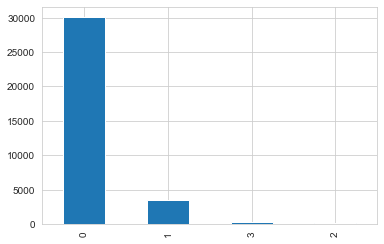

In [21]:
df.Turbidity_level.value_counts().plot.bar()

The value counts and above bar chart of the value counts indicates an obvious imbalance. 

## Create month and seasonal variable

In [22]:
# Creating monthly variable
df['Month'] = df['Measurement Timestamp'].apply(lambda time: time.month)

In [23]:
df['Measurement Timestamp'].dt.month.value_counts()

7    9867
6    9490
8    9396
9    3665
5    1746
Name: Measurement Timestamp, dtype: int64

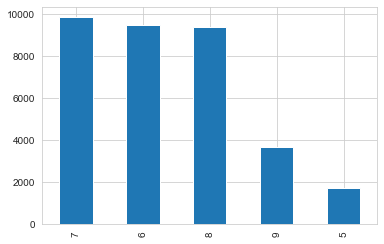

In [24]:
df.Month.value_counts().plot.bar();

In [25]:
df['date_offset'] = (df['Measurement Timestamp'].dt.month*100 + df['Measurement Timestamp'].dt.day - 320)%1300

df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'],include_lowest=True)

# credit: https://stackoverflow.com/a/60285720

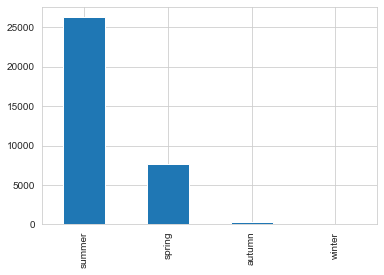

In [26]:
df.season.value_counts().plot.bar();

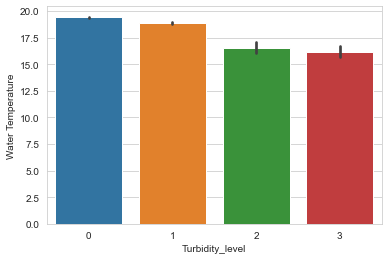

In [27]:
sns.barplot(y='Water Temperature', x='Turbidity_level', data=df);

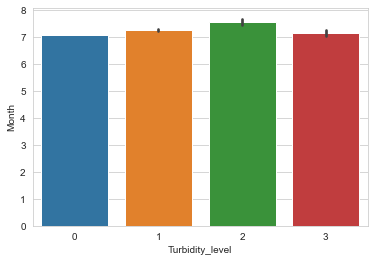

In [28]:
sns.barplot(y='Month', x='Turbidity_level', data=df);

In [29]:
features_list = ['Measurement Timestamp', 'Month', 'Water Temperature']

In [30]:
# Create feature variable and target variable
X = df[features_list]
y = df['Turbidity_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=42)

## Baseline Model

Our first model will always predict the majority target(turbidity level) class. 

In [31]:
# Instantiate the dummy classifier
baseline_model = DummyClassifier(strategy="most_frequent")

In [32]:
# Fit the classifier on training data
baseline_model.fit(X_train, y_train)

DummyClassifier(strategy='most_frequent')

In [33]:
baseline_model.predict(X_train)[:30] == y_train[:30] 

19403     True
10663     True
13136     True
11154     True
17574     True
12936     True
13200     True
17147     True
2813      True
17569     True
24430     True
28938     True
11323     True
16391     True
23067    False
12465     True
5197      True
6548      True
10131     True
28732     True
10762    False
27069     True
28052     True
7601      True
27215     True
875      False
27611     True
3993      True
25056     True
34342     True
Name: Turbidity_level, dtype: bool

## Dummy Model Evaluation

In [34]:
cv_results = cross_val_score(baseline_model, X_train, y_train, cv=7)
cv_results.mean()

0.8793271739313536

As expected , the mean cross-validated accuracy is c.88%. This ordinarily is a good score, but you may recall that the target variable is heavily imbalanced, hence, this result.

In [35]:
# Plot confusion matrix:
print(confusion_matrix(y_train, baseline_model.predict(X_train)))

[[22531     0     0     0]
 [ 2662     0     0     0]
 [  162     0     0     0]
 [  268     0     0     0]]


In [36]:
# Calculate the accuracy 
accuracy_score(y_train, baseline_model.predict(X_train))

0.8793271669983999

Accuracy will be our preferred evaluation metric. This is because there is equal emphasis on maximizing true positives and true negatives, while minizing type I and II errors. Making a false prediction could be undesirable either ways: loss of income for beach operators or risk of falling sick for beach-goers.

## First Simple Model - Logistic Regression

In our first logistic regression model, we will be adding a few features to the ones we used in the dummy baseline model. The new features are not numeric so we will have to perform some transformation on them.

In [37]:
lr_features_list = ['Month', 'Water Temperature','Beach Name','season']
X = df[lr_features_list]
y = df['Turbidity_level']

In [38]:
# train-test split again
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Handling Categorical Values: OneHotEncoding

In [39]:
# Instantiate OneHotEncoder object
# ohe = OneHotEncoder(handle_unknown='ignore',sparse=True)

# Fit encoder object to X_train 
# X_train_transformed = ohe.fit_transform(X_train[['Beach Name','season']])

#Transform fitted object on training and testing data
# X_test_transformed = ohe.transform(X_test[['Beach Name','season']])

In [40]:
object_cols = ['Beach Name','season']

# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[object_cols]))
OH_cols_test = pd.DataFrame(OH_encoder.transform(X_test[object_cols]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X_train.index
OH_cols_test.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_test = X_test.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)

# credit: https://www.kaggle.com/code/alexisbcook?scriptVersionId=79127496&cellId=14

In [41]:
lr = LogisticRegression(random_state=21,class_weight='balanced',max_iter=1000)

In [42]:
lr.fit(OH_X_train,y_train)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=21)

In [43]:
y_hat_train = lr.predict(OH_X_train)

In [44]:
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

           0       0.94      0.55      0.69     22531
           1       0.16      0.33      0.22      2662
           2       0.04      0.63      0.07       162
           3       0.03      0.58      0.07       268

    accuracy                           0.52     25623
   macro avg       0.29      0.52      0.26     25623
weighted avg       0.85      0.52      0.63     25623



In [45]:
print(accuracy_score(y_train, y_hat_train))

0.5242555516528119


This model does much worse than the baseline model but is a more realistic starting point going forward.

In [46]:
y_pred = lr.predict(OH_X_test)

In [47]:
print(accuracy_score(y_test, y_pred))

0.5326074230183819


In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.55      0.70      7552
           1       0.16      0.34      0.22       853
           2       0.03      0.58      0.06        45
           3       0.03      0.51      0.06        91

    accuracy                           0.53      8541
   macro avg       0.29      0.50      0.26      8541
weighted avg       0.86      0.53      0.64      8541



## 2nd Logistic Regression Model

To start this second logistic model, we would be addressing the imbalance in target variable class distribution making use of **SMOTE**. I will also incorporate the time vaiable to see how much of an effect it has on the turbidity levels. 

## Address variable target class imbalance

We begin the second logistic model design by addressing the variable class imabalnce as noticed earlier using **Synthetic Minority Oversampling**. Before that,  we carry-out a train-test split of the variables.

In [49]:
# train-test split of variables
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=42)

In [51]:
object_cols = ['Beach Name','season']

# Apply one-hot encoder to each column with categorical data
enc_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc_cols_train = pd.DataFrame(enc_encoder.fit_transform(X_train[object_cols]))
enc_cols_test = pd.DataFrame(enc_encoder.transform(X_test[object_cols]))

# One-hot encoding removed index; put it back
enc_cols_train.index = X_train.index
enc_cols_test.index = X_test.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X_train.drop(object_cols, axis=1)
num_X_test = X_test.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
X_train_enc = pd.concat([num_X_train, enc_cols_train], axis=1)
X_test_enc = pd.concat([num_X_test, enc_cols_test], axis=1)


In [52]:
# oversample the minority classes of the dependent variable

smote = SMOTE(random_state=2022, sampling_strategy='auto')

X_train_resampled, y_train_resampled = smote.fit_resample(X_train_enc, y_train) 
# Preview synthetic sample class distribution
# print('Synthetic sample class distribution: \n')
# print(y_train_resampled.value_counts())

In [53]:
X_train_resampled.head()

,Month,Water Temperature,0,1,2,3,4,5,6,7,8
0,5,17.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,8,20.2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,9,19.8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,8,22.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,7,20.3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [54]:
X_train_resampled.shape

(84076, 11)

In [55]:
y_train_resampled.shape

(84076,)

In [56]:
clf = MultinomialNB()

In [57]:
clf.fit(X_train_resampled, y_train_resampled)

MultinomialNB()

In [58]:
y_hat_nb = clf.predict(X_train_resampled)

In [59]:
y_hat_nb.shape == y_train_resampled.shape

True

In [60]:
accuracy_score(y_train_resampled,y_hat_nb)

0.5083376944669109

In [68]:
log = LogisticRegression(random_state=21,class_weight='balanced',max_iter=1000,solver='saga',penalty='l1')

In [69]:
log.fit(X_train_resampled,y_train_resampled)

/Users/rotimiadejumo/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1',
                   random_state=21, solver='saga')

In [70]:
y_hat_train = lr.predict(X_train_resampled)

In [71]:
print(classification_report(y_train_resampled, y_hat_train))

              precision    recall  f1-score   support

           0       0.59      0.55      0.57     21019
           1       0.37      0.33      0.35     21019
           2       0.58      0.63      0.60     21019
           3       0.53      0.58      0.55     21019

    accuracy                           0.52     84076
   macro avg       0.52      0.52      0.52     84076
weighted avg       0.52      0.52      0.52     84076



In [72]:
print(accuracy_score(y_test, lr.predict(X_test_enc)))

0.5287804878048781
